In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## About Dataset

The dataset is derived from publicly available **MIMIC-III** database. The concentration is on **ICU-admitted** patients with **Heart Failure**. The goal of the project is to study and classify the mortality based on *DEMOGRAPHIC INFROMATION, VITAL SIGNS, LAB RESULTS* and *DIAGNOSES*.

In [27]:
data = pd.read_csv('data01.csv')
data.head()

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0.0,75,2,31.824842,1,0,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


In [28]:
print('Number of observations:', data.shape[0])

Number of observations: 1177


## Data Preprocessing

Before moving forward, the data and variables need to be preprocessed.

1. *group* and *ID* columns are not necessary, so they should be dropped.

In [29]:
cleaned_data = data.drop(['group', 'ID'], axis=1)

2. Currently all variables are numerical, including *outcome*. So let us cast that variable to categorical. The *gender* column has values of 1 and 2, for consistency let us use 0 and 1 values for it as well.

In [30]:
cleaned_data.dtypes

outcome                     float64
age                           int64
gendera                       int64
BMI                         float64
hypertensive                  int64
atrialfibrillation            int64
CHD with no MI                int64
diabetes                      int64
deficiencyanemias             int64
depression                    int64
Hyperlipemia                  int64
Renal failure                 int64
COPD                          int64
heart rate                  float64
Systolic blood pressure     float64
Diastolic blood pressure    float64
Respiratory rate            float64
temperature                 float64
SP O2                       float64
Urine output                float64
hematocrit                  float64
RBC                         float64
MCH                         float64
MCHC                        float64
MCV                         float64
RDW                         float64
Leucocyte                   float64
Platelets                   

In [31]:
cleaned_data['gendera'] = data['gendera'] - 1

3. Now, let us deal with *null* values.

In [32]:
cleaned_data.isnull().sum()

outcome                       1
age                           0
gendera                       0
BMI                         215
hypertensive                  0
atrialfibrillation            0
CHD with no MI                0
diabetes                      0
deficiencyanemias             0
depression                    0
Hyperlipemia                  0
Renal failure                 0
COPD                          0
heart rate                   13
Systolic blood pressure      16
Diastolic blood pressure     16
Respiratory rate             13
temperature                  19
SP O2                        13
Urine output                 36
hematocrit                    0
RBC                           0
MCH                           0
MCHC                          0
MCV                           0
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils                 144
Basophils                   259
Lymphocyte                  145
PT      

We can see that there is 1 row whose *outcome* is NA, we'll drop that row. The other columns that include NA values make up a significant amount, so we cannot drop those rows. On the other hand, those columns are very important for decision, so we cannot exclude the whole columns from the training process as well. 

In [33]:
cleaned_data[cleaned_data.isnull()['heart rate']].isnull().sum()

outcome                      1
age                          0
gendera                      0
BMI                          7
hypertensive                 0
atrialfibrillation           0
CHD with no MI               0
diabetes                     0
deficiencyanemias            0
depression                   0
Hyperlipemia                 0
Renal failure                0
COPD                         0
heart rate                  13
Systolic blood pressure     13
Diastolic blood pressure    13
Respiratory rate            13
temperature                 13
SP O2                       13
Urine output                13
hematocrit                   0
RBC                          0
MCH                          0
MCHC                         0
MCV                          0
RDW                          0
Leucocyte                    0
Platelets                    0
Neutrophils                  0
Basophils                    0
Lymphocyte                   0
PT                           0
INR     

We can observe from the above results, that for the rows having NA *heart rate*, the other vital signs are also NA. And as the number of rows is low, it's better to drop these rows.

In [34]:
cleaned_data = cleaned_data.dropna(subset=['heart rate'])
cleaned_data.isnull().sum()

outcome                       0
age                           0
gendera                       0
BMI                         208
hypertensive                  0
atrialfibrillation            0
CHD with no MI                0
diabetes                      0
deficiencyanemias             0
depression                    0
Hyperlipemia                  0
Renal failure                 0
COPD                          0
heart rate                    0
Systolic blood pressure       3
Diastolic blood pressure      3
Respiratory rate              0
temperature                   6
SP O2                         0
Urine output                 23
hematocrit                    0
RBC                           0
MCH                           0
MCHC                          0
MCV                           0
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils                 144
Basophils                   259
Lymphocyte                  145
PT      

For the remaining missing values, let us replace them with a statistical metric, the column means specifically.

In [35]:
cleaned_data = cleaned_data.fillna(cleaned_data.mean())
cleaned_data.head()

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,0.0,72,0,37.588179,0,0,0,1,1,0,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,0.0,75,1,30.189940,0,0,0,0,1,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,0.0,83,1,26.572634,0,0,0,0,1,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,0.0,43,1,83.264629,0,0,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,0.0,75,1,31.824842,1,0,0,0,1,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


## Exploratory Data Analysis

In [36]:
cleaned_data.describe()

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
count,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,...,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000
mean,0.135739,74.039519,0.526632,30.189940,0.717354,0.452749,0.083333,0.420103,0.338488,0.118557,...,138.906319,8.502840,102.290674,13.923373,2.121390,7.378532,26.920417,1.853426,45.535356,48.722509
std,0.342658,13.464075,0.499505,8.468460,0.450479,0.497976,0.276504,0.493787,0.473399,0.323405,...,4.147354,0.570618,5.316437,2.663190,0.251587,0.058693,5.176004,0.887770,11.069638,12.909146
min,0.000000,19.000000,0.000000,13.346801,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,114.666667,6.700000,80.266667,6.636364,1.400000,7.090000,12.857143,0.500000,18.750000,15.000000
25%,0.000000,65.000000,0.000000,25.264054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,136.666667,8.150000,99.000000,12.228632,1.955556,7.350000,23.488636,1.300000,39.000000,40.000000
50%,0.000000,77.000000,1.000000,30.189940,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,139.258333,8.500000,102.500000,13.666667,2.093725,7.378532,26.472222,1.800000,45.535356,55.000000
75%,0.000000,85.000000,1.000000,32.116293,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,141.603846,8.870357,105.513889,15.404167,2.243254,7.410000,29.832386,2.025000,47.347222,55.000000
max,1.000000,99.000000,1.000000,104.970366,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,154.736842,10.950000,122.526316,25.500000,4.072727,7.580000,47.666667,8.333333,98.600000,75.000000


- From the data description above it is obvious that there is an imbalance in data in terms of *outcome* variable. Later we'll need to deal with this imbalance.
- The interquartile range of *age* is [65, 85], which is logical as the heart failure is more common among elderly patients.
- The *gender* column is balanced, number of male and female patients is almost equal (mean~0.53).
- The interquartile range of *BMI* is [~25, ~32]. Considering the fact that normal BMI is <25, and being overweight is a very serious risk factor for heart failure, these results are also expected.
- The other binary columns indicating imbalance are *CHD with no MI* (most of the patients didn't have heart attack at the time of admission) and *depression* (most of the patients had depression at the time of admission, again very important risk factor for HF).

<AxesSubplot:xlabel='outcome', ylabel='count'>

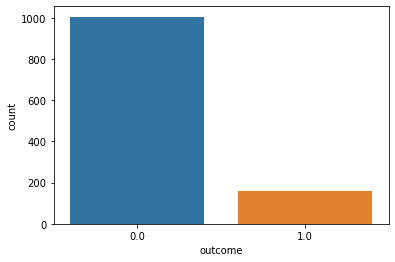

In [38]:
sns.countplot(data=cleaned_data, x="outcome")

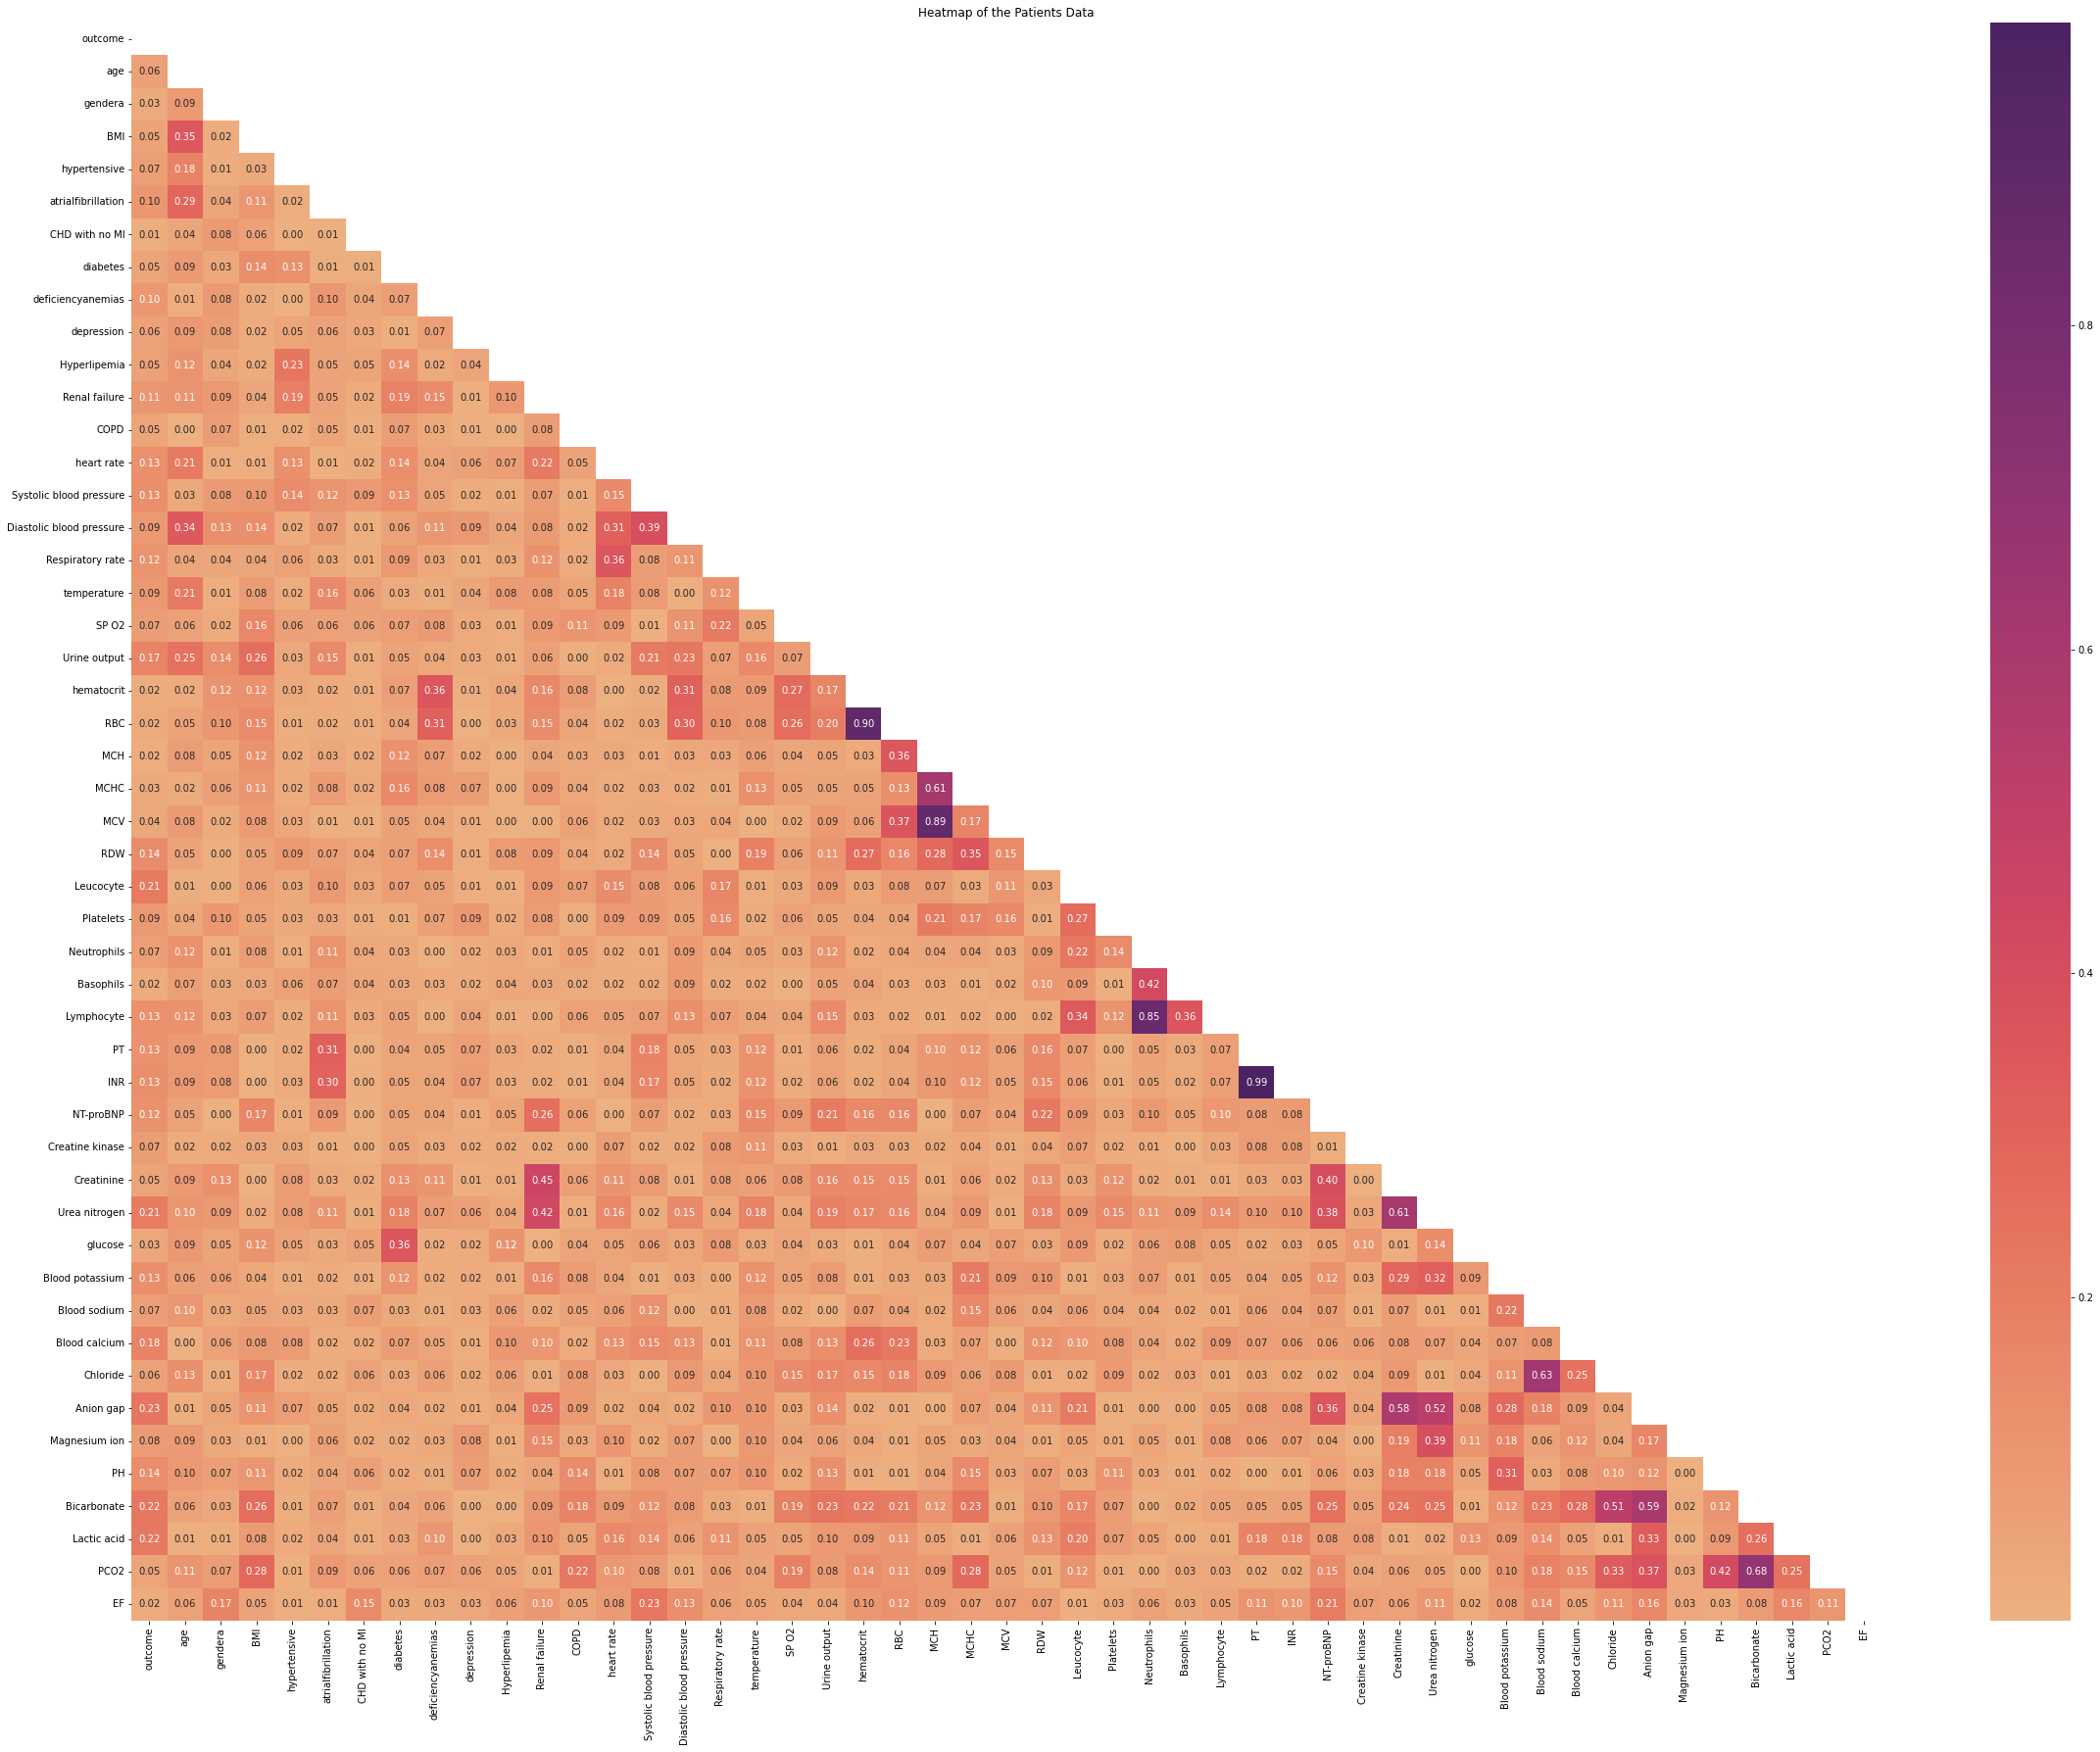

In [44]:
corr_matrix = np.abs(cleaned_data.corr())
mask = np.triu(np.ones_like(corr_matrix) > 0)

plt.figure(figsize = (40, 30))
sns.heatmap(corr_matrix, mask=mask, cmap='flare', annot=True, fmt='.2f')
plt.title('Heatmap of the Patients Data')
plt.show()

From the heatmap above we can see very strong correlations between these pairs:
- RBC and hematocrit
- MCV and MCH
- Lymphocyte and Neutrophils
- INR and PT

For cleaning the linear dependencies, we are going to drop one of the columns for each pair.

In [45]:
cleaned_data = cleaned_data.drop(['hematocrit', 'MCH', 'Neutrophils', 'PT'], axis=1)

And if we look at the correlations between *outcome* and othher variables, the strongest corellated variables are *Anion Gap, Bicarbonate, Lactic acid, Leucocyte* and *Urea Nitrogen*.

## Methodology

We are going to experiment with *Logistic Regression* , *Random Forest* and *Gradient Boosting* algorithms, as these models are flexible for adapting to imbalanced data.

### 1. Data Split

The data is split between training(80%) and test(20%) sets.

In [83]:
X = cleaned_data.iloc[:, 1:]
y = cleaned_data.iloc[:, 0]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=cleaned_data['outcome'])

In [84]:
def evaluate(gt, pred):
    print("Precision : ", precision_score(gt, pred, average = 'micro'))
    print("Recall : ", recall_score(gt, pred, average = 'micro'))
    print("Accuracy : ", accuracy_score(gt, pred))
    print("F1 Score : ", f1_score(gt, pred, average = 'micro'))

In [96]:
def roc_auc(model, real_X, real_y):
    y_scores = model.predict_proba(real_X)[:, 1]
    fpr, tpr, thresholds = roc_curve(real_y, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    sns.lineplot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    sns.lineplot([0, 1], [0, 1], linestyle='--', color='navy')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    

### 1. Logistic Regression

In [85]:
lr_model = LogisticRegression(class_weight='balanced', max_iter=10000)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

In [86]:
evaluate(y_test, y_pred_lr)

Precision :  0.7725321888412017
Recall :  0.7725321888412017
Accuracy :  0.7725321888412017
F1 Score :  0.7725321888412017


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


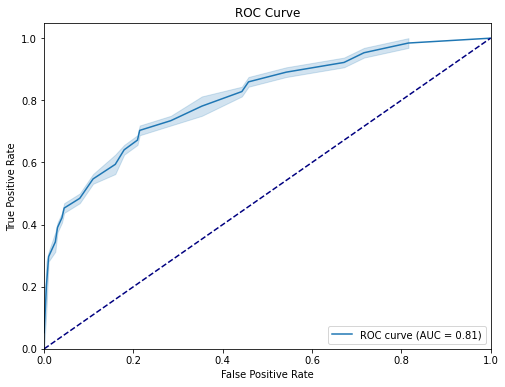

In [97]:
roc_auc(lr_model, X_test, y_test)

### 2. Gradient Boosting

In [87]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)

In [88]:
evaluate(y_test, y_pred_gb)

Precision :  0.8583690987124464
Recall :  0.8583690987124464
Accuracy :  0.8583690987124464
F1 Score :  0.8583690987124464


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


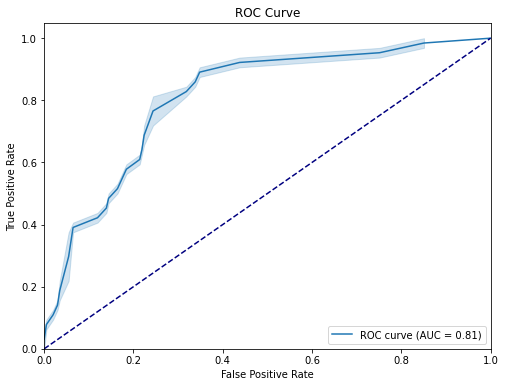

In [99]:
roc_auc(gb_model, X_test, y_test)

### 3. Random Forest

In [103]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

In [91]:
evaluate(y_test, y_pred_rf)

Precision :  0.871244635193133
Recall :  0.871244635193133
Accuracy :  0.871244635193133
F1 Score :  0.871244635193133


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


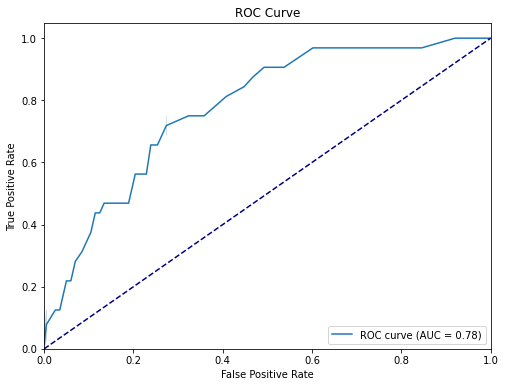

In [100]:
roc_auc(rf_model, X_test, y_test)

### Conclusion

From the results above we can see, that in terms of F1 Score, the *Random Forest* method performs the best, and the *Gradient Boosting* is slightly worse. But when we look at the ROC curve and AUC, *Gradient Boosting* has better performance. Thus, both methods can be considered optimal for the task.

## Future Work

As an improvement of above methods, several steps can be taken:
- Study the class imbalance more thoroughly and use upsampling techniques
- Tune hyperparameters of the prediction methods and choose the best one
- Study the ECG waveforms data and merge into the process